In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import statistics
%matplotlib inline

In [2]:
df = pd.read_csv('../../../data/Df with State Rank plus binned columns.csv',index_col="Unnamed: 0")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Coordinates,School District,State Rank
0,7129300520,10/13/2014,221900.0,small,minimal,1180,5650,1.0,NaN,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,"(-122.257, 47.5112)",seattle,11-50
1,6414100192,12/9/2014,538000.0,small,minimal,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,"(-122.319, 47.721000000000004)",seattle,11-50
2,5631500400,2/25/2015,180000.0,small,minimal,770,10000,1.0,0.0,0.0,...,1933,NaN,98028,47.7379,-122.233,2720,8062,"(-122.23299999999999, 47.7379)",northshore,Top_ten
3,2487200875,12/9/2014,604000.0,small,average,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,"(-122.39299999999999, 47.5208)",seattle,11-50
4,1954400510,2/18/2015,510000.0,small,minimal,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,"(-122.045, 47.6168)",lake washington,Top_ten


In [3]:
df = df.drop_duplicates()

In [4]:
df.date = df["date"].map(lambda x: x.split("/")[0])

In [5]:
df['date'] = df['date'].map(lambda x: int(x))

In [6]:
df.waterfront = df.waterfront.replace(np.NaN, 0.0)

In [7]:
df = df.fillna(0.0)

In [8]:
df.columns = df.columns.str.replace(" ", "_")

In [9]:
df.columns = df.columns.str.lower().str.replace(".0", "")

In [10]:
df_corr_price = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corr_price

price            1.000000
sqft_living      0.700673
sqft_above       0.603899
sqft_living15    0.585329
view             0.394476
lat              0.306950
waterfront       0.263315
floors           0.259331
yr_renovated     0.119919
sqft_lot         0.088113
sqft_lot15       0.080797
yr_built         0.049736
zipcode          0.049642
id               0.019255
long             0.018177
date             0.009518
Name: price, dtype: float64

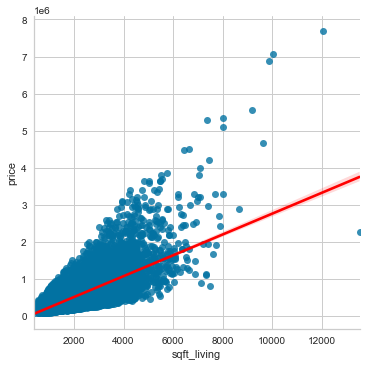

In [11]:
sns.lmplot(x='sqft_living', y='price', data=df, line_kws={'color': 'red'})
plt.show();

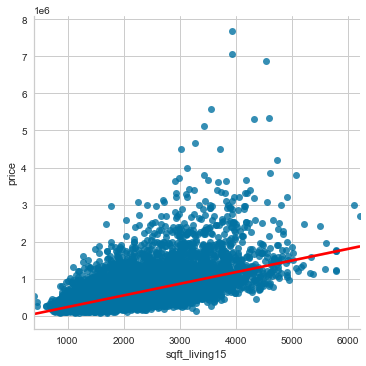

In [12]:
sns.lmplot(x='sqft_living15', y='price', data=df, line_kws={'color': 'red'})
plt.show();

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21234 entries, 0 to 21233
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21234 non-null  int64  
 1   date             21234 non-null  int64  
 2   price            21234 non-null  float64
 3   bedrooms         21234 non-null  object 
 4   bathrooms        21234 non-null  object 
 5   sqft_living      21234 non-null  int64  
 6   sqft_lot         21234 non-null  int64  
 7   floors           21234 non-null  float64
 8   waterfront       21234 non-null  float64
 9   view             21234 non-null  float64
 10  condition        21234 non-null  object 
 11  grade            21234 non-null  object 
 12  sqft_above       21234 non-null  int64  
 13  sqft_basement    21234 non-null  object 
 14  yr_built         21234 non-null  int64  
 15  yr_renovated     21234 non-null  float64
 16  zipcode          21234 non-null  int64  
 17  lat         

In [14]:
dropped_columns = ['school_district', 'coordinates',
                  'sqft_lot', 'sqft_lot15', 'sqft_living15', 'long', 'zipcode', 'yr_renovated',
                  'yr_built', 'sqft_basement', 'grade', 'condition', 'view', 'floors',
                  'bedrooms', 'id', 'date', 'price']

# **Baseline Model no Change**

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
predictors = df.drop(columns=dropped_columns)
predict= '+'.join(predictors)
f = 'price ~' + predict
model_df = ols(formula=f, data=df).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     4231.
Date:                Fri, 02 Jul 2021   Prob (F-statistic):               0.00
Time:                        09:03:46   Log-Likelihood:            -2.9207e+05
No. Observations:               21234   AIC:                         5.842e+05
Df Residuals:                   21225   BIC:                         5.842e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -3.413e+07    5.4e+05    -63.217      0.000   -3.52e+07   -3.31e+07
bathrooms[T.many]       9.381e+05   5.32e+04     17.632      0.000    8.34e+05    1.04e+06
bathrooms[T.minimal]   -1.034e+05   5659.605    -18.265      0.000   -1.14e+05   -9.23e+04
state_rank[T.51-above]  -922.5169   4139.621     -0.223      0.824   -9036.488    7191.454
state_rank[T.Top_ten]    128.0513   3541.303      0.036      0.971   -6813.171    7069.274
sqft_living              228.7270      3.752     60.954      0.000     221.372     236.082
waterfront              8.728e+05   1.91e+04     45.680      0.000    8.35e+05     9.1e+05
sqft_above                16.4125      3.939      4.166      0.000       8.691      24.134
lat                     7.201e+05   1.13e+04     63.472      0.000    6.98e+05    7.42e+05
==============================================================================
Omnibus:                    13746.579   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           523323.418
Skew:                           2.571   Prob(JB):                         0.00
Kurtosis:                      26.771   Cond. No.                     1.03e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
dropped_columns_new = ['school_district', 'coordinates',
                  'sqft_lot', 'sqft_lot15', 'long', 'zipcode', 'yr_renovated',
                  'yr_built', 'view', 'floors', 'id', 'date']

In [17]:
df = df.drop(columns=dropped_columns_new)

In [18]:
df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
0,221900.0,small,minimal,1180,0.0,good,good,1180,0.0,47.5112,1340,11-50
1,538000.0,small,minimal,2570,0.0,good,good,2170,400.0,47.7210,1690,11-50
2,180000.0,small,minimal,770,0.0,good,bad,770,0.0,47.7379,2720,Top_ten
3,604000.0,small,average,1960,0.0,very_good,good,1050,910.0,47.5208,1360,11-50
4,510000.0,small,minimal,1680,0.0,good,good,1680,0.0,47.6168,1800,Top_ten


In [19]:
df["sqft_basement"] = df["sqft_basement"].replace("0.0", np.nan)
df["sqft_basement"] = df["sqft_basement"].replace("?", np.nan)
df["sqft_basement"] = df["sqft_basement"].fillna(0.0)
df["sqft_basement"] = df["sqft_basement"].map(lambda x: float(x))

In [20]:
while df["sqft_basement"].loc[df["sqft_basement"] == 0].count() > 0:
    for i in range(0, len(df)):
        if df["sqft_basement"].iloc[i] == 0:
            df["sqft_basement"].iloc[i] = 0.1

C:\Users\Catherine\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [113]:
df_baseline = df.copy()

## Baseline Model Logged

In [134]:
continuous = ["sqft_above", "price",'sqft_living',"sqft_basement","sqft_living15","lat"]

categorical = ['bedrooms',"grade",'condition',"bathrooms","state_rank","waterfront"]

df_log = np.log(df_baseline[continuous])
df_log.columns = [f"{column}_log" for column in df_baseline[continuous]]

    
df_norm = (np.log(df_baseline[continuous]) - np.mean(np.log(df_baseline[continuous])))/np.std(np.log(df_baseline[continuous]))
df_norm.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

oe=OrdinalEncoder(categories=[['small', 'moderate', 'excessive'],["bad","good",'very_good' ],["bad","good",'very_good'],['minimal', 'average','many'],['51-above','11-50','Top_ten' ],[0,1]])
df_ohe=pd.DataFrame(oe.fit_transform(df_baseline[['bedrooms',"grade",'condition',"bathrooms","state_rank","waterfront"]]))
df2 =df_norm.join(df_ohe, how="inner")
# enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
# df_ohe=pd.DataFrame(enc.fit_transform(df_low_price_pre[categorical]))
# df_ohe.columns =enc.get_feature_names(['bedrooms',"grade",'condition',"bathrooms","state_rank"])

# df_ohe = pd.get_dummies(df_low_price_pre[categorical], columns=categorical, drop_first = True)
# df_low_price =df_norm.join(df_ohe, how="inner")
# df_low_price = pd.concat([df_norm, df_ohe], axis = 1)
#df_low_price = pd.concat([df_final1,df_low_price_pre.drop(columns=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront','condition', 'grade',
 #      'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'])], axis=1)

In [135]:
while df2["sqft_basement_log"].loc[df2["sqft_basement_log"] == -0.78797255].count() > 0:
    for i in range(0, len(df2)):
        if df2["sqft_basement_log"].iloc[i] == -0.78797255:
            df2["sqft_basement_log"].iloc[i] = -2
# log base e of 0 on a graph could be read as -2. It technically goes to negative infinity but -2 will have to suffice for my estimations.

In [149]:
df2.columns

Index([   'sqft_above_log',         'price_log',   'sqft_living_log',
       'sqft_basement_log', 'sqft_living15_log',           'lat_log',
                         0,                   1,                   2,
                         3,                   4,                   5],
      dtype='object')

In [152]:
# dropped_columns ["sqft_above_log",'sqft_living_log',"sqft_basement_log","sqft_living15_log","lat_log",0,1,2,3,4,5]
f = df2['price_log'],df2.drop(columns="price_log")
model_df2 = ols(formula=f, data=df2).fit()
model_df2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.685
Model:                            OLS   Adj. R-squared (uncentered):              0.685
Method:                 Least Squares   F-statistic:                              4189.
Date:                Fri, 02 Jul 2021   Prob (F-statistic):                        0.00
Time:                        10:17:09   Log-Likelihood:                         -17876.
No. Observations:               21234   AIC:                                  3.577e+04
Df Residuals:                   21223   BIC:                                  3.586e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
sqft_above_log        0.2603      0.017     15.472      0.000       0.227       0.293
sqft_living_log       0.1912      0.017     11.241      0.000       0.158       0.225
sqft_basement_log     0.1344      0.009     15.523      0.000       0.117       0.151
sqft_living15_log     0.2099      0.006     35.121      0.000       0.198       0.222
lat_log               0.4152      0.004    105.942      0.000       0.408       0.423
0                    -0.1074      0.015     -7.377      0.000      -0.136      -0.079
1                     0.0407      0.009      4.655      0.000       0.024       0.058
2                     0.0217      0.006      3.490      0.000       0.010       0.034
3                     0.2683      0.014     19.535      0.000       0.241       0.295
4                    -0.0621      0.005    -12.576      0.000      -0.072      -0.052
5                     1.3879      0.047     29.502      0.000       1.296       1.480
==============================================================================
Omnibus:                      244.336   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              296.037
Skew:                           0.196   Prob(JB):                     5.20e-65
Kurtosis:                       3.425   Cond. No.                         25.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Lower Price Model

In [114]:
df_low_price_pre = df.loc[df['price']< 300000]
df_low_price_pre

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
0,221900.0,small,minimal,1180,0.0,good,good,1180,0.1,47.5112,1340,11-50
2,180000.0,small,minimal,770,0.0,good,bad,770,0.1,47.7379,2720,Top_ten
6,257500.0,small,minimal,1715,0.0,good,good,1715,0.1,47.3097,2238,51-above
7,291850.0,small,minimal,1060,0.0,good,good,1060,0.1,47.4095,1650,51-above
8,229500.0,small,minimal,1780,0.0,good,good,1050,730.0,47.5123,1780,51-above
...,...,...,...,...,...,...,...,...,...,...,...,...
21168,295000.0,small,minimal,1230,0.0,good,good,1230,0.1,47.4380,1440,51-above
21195,274800.0,small,minimal,1410,0.0,good,good,1410,0.1,47.5171,1410,11-50
21199,269950.0,small,minimal,2244,0.0,good,good,2244,0.1,47.2606,2077,11-50
21219,288790.0,small,minimal,1290,0.0,good,good,1060,230.0,47.5400,1370,51-above


In [115]:
df_low_price_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4374 entries, 0 to 21228
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4374 non-null   float64
 1   bedrooms       4374 non-null   object 
 2   bathrooms      4374 non-null   object 
 3   sqft_living    4374 non-null   int64  
 4   waterfront     4374 non-null   float64
 5   condition      4374 non-null   object 
 6   grade          4374 non-null   object 
 7   sqft_above     4374 non-null   int64  
 8   sqft_basement  4374 non-null   float64
 9   lat            4374 non-null   float64
 10  sqft_living15  4374 non-null   int64  
 11  state_rank     4374 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 444.2+ KB


In [116]:
continuous = ["sqft_above", "price",'sqft_living']

categorical = ['bedrooms',"grade",'condition',"bathrooms","state_rank"]

df_log = np.log(df_low_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

    
df_norm = (np.log(df_low_price_pre[continuous]) - np.mean(np.log(df_low_price_pre[continuous])))/np.std(np.log(df_low_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

oe=OrdinalEncoder(categories=[['small', 'moderate', 'excessive'],["bad","good",'very_good' ],["bad","good",'very_good'],['minimal', 'average','many'],['51-above','11-50','Top_ten' ]])
df_ohe=pd.DataFrame(oe.fit_transform(df_low_price_pre[['bedrooms',"grade",'condition',"bathrooms","state_rank"]]))
df_low_price =df_norm.join(df_ohe, how="inner")
# enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
# df_ohe=pd.DataFrame(enc.fit_transform(df_low_price_pre[categorical]))
# df_ohe.columns =enc.get_feature_names(['bedrooms',"grade",'condition',"bathrooms","state_rank"])

# df_ohe = pd.get_dummies(df_low_price_pre[categorical], columns=categorical, drop_first = True)
# df_low_price =df_norm.join(df_ohe, how="inner")
# df_low_price = pd.concat([df_norm, df_ohe], axis = 1)
#df_low_price = pd.concat([df_final1,df_low_price_pre.drop(columns=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront','condition', 'grade',
 #      'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'])], axis=1)

In [117]:
display(df_norm.isna().sum(),df_ohe.isna().sum(),df_low_price.isna().sum())

sqft_above_log     0
price_log          0
sqft_living_log    0
dtype: int64

0    0
1    0
2    0
3    0
4    0
dtype: int64

sqft_above_log     0
price_log          0
sqft_living_log    0
0                  0
1                  0
2                  0
3                  0
4                  0
dtype: int64

In [118]:
df_low_price.tail(25)

,sqft_above_log,price_log,sqft_living_log,0,1,2,3,4
4245,-0.352895,-1.296646,-0.640213,0.0,1.0,1.0,0.0,2.0
4246,-0.414128,-0.402234,0.542972,0.0,1.0,1.0,0.0,0.0
4249,0.152844,-1.165447,-0.169485,0.0,1.0,1.0,0.0,0.0
4251,-0.147016,-0.914701,-0.448587,0.0,1.0,1.0,0.0,1.0
4257,-0.949208,-1.921453,-1.195246,0.0,1.0,1.0,0.0,1.0
4258,0.073699,-0.314933,-0.243151,0.0,1.0,1.0,0.0,1.0
4260,0.403873,0.274020,1.498615,0.0,1.0,1.0,0.0,2.0
4273,0.726327,-1.598754,0.364298,0.0,1.0,1.0,0.0,2.0
4278,-0.476505,0.312061,-0.755267,0.0,1.0,1.0,0.0,1.0
4287,1.836602,1.006803,1.397712,0.0,1.0,1.0,0.0,2.0


In [119]:
X_low = df_low_price.drop(columns=['price_log'], axis=1) 
y_low = df_low_price[['price_log']]
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, random_state=50, test_size=.25)

In [120]:
X_train_low

,sqft_above_log,sqft_living_log,0,1,2,3,4
1908,2.764997,2.261838,0.0,1.0,1.0,0.0,1.0
2184,1.488499,1.073707,0.0,1.0,2.0,0.0,1.0
1126,-0.604871,-0.874746,0.0,0.0,1.0,0.0,2.0
2035,1.080121,0.693600,0.0,1.0,2.0,0.0,0.0
675,-0.772601,0.196360,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
1237,0.126670,-0.193847,0.0,0.0,1.0,0.0,0.0
465,0.918290,0.542972,0.0,1.0,1.0,0.0,1.0
4141,0.230155,-0.097526,0.0,0.0,2.0,0.0,1.0
2201,0.834333,0.464827,0.0,1.0,2.0,0.0,2.0


In [121]:
f = y_train_low, X_train_low
model_low = ols(formula=f, data=X_train_low).fit()
model_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.217
Model:                            OLS   Adj. R-squared (uncentered):              0.209
Method:                 Least Squares   F-statistic:                              27.90
Date:                Fri, 02 Jul 2021   Prob (F-statistic):                    5.78e-34
Time:                        10:05:23   Log-Likelihood:                         -929.37
No. Observations:                 713   AIC:                                      1873.
Df Residuals:                     706   BIC:                                      1905.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqft_above_log      0.0340      0.057      0.597      0.550      -0.078       0.146
sqft_living_log     0.4368      0.056      7.766      0.000       0.326       0.547
0                  -0.0174      0.216     -0.081      0.936      -0.441       0.407
1                  -0.0131      0.065     -0.203      0.839      -0.140       0.114
2                  -0.0279      0.043     -0.652      0.515      -0.112       0.056
3                  -0.6612      0.450     -1.468      0.142      -1.545       0.223
4                  -0.0208      0.042     -0.499      0.618      -0.103       0.061
==============================================================================
Omnibus:                       91.925   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.405
Skew:                          -0.834   Prob(JB):                     1.33e-33
Kurtosis:                       4.522   Cond. No.                         26.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
df_low_price.corr()['price_log'].map(abs).sort_values(ascending=False)

price_log          1.000000
sqft_living_log    0.437888
sqft_above_log     0.351663
4                  0.047681
3                  0.025228
1                  0.020836
0                  0.019080
2                  0.005755
Name: price_log, dtype: float64

In [123]:
linreg_low = LinearRegression()
linreg_low.fit(X_train_low, y_train_low)

predicted_y_low = linreg_low.predict(X_test_low) 

linreg_low.score(X_test_low, y_test_low)

0.11486542870474126

In [124]:
lr_low = LinearRegression()

In [125]:
lr_low.fit(X_train_low, y_train_low)

LinearRegression()

In [126]:
from sklearn.model_selection import KFold

folds = KFold(10, shuffle = True)
train_train_scores = []
train_test_scores = []
train_train_rmse = []
train_test_rmse = []
for train_ind, test_ind in folds.split(X_train_low):
    X_train_low_train = X_train_low.iloc[train_ind]
    X_train_low_test = X_train_low.iloc[test_ind]
    y_train_low_train = y_train_low.iloc[train_ind]
    y_train_low_test = y_train_low.iloc[test_ind]
    linreg_low1 = LinearRegression()
    linreg_low1.fit(X_train_low_train, y_train_low_train)
    train_train_scores.append(linreg_low1.score(X_train_low_train, y_train_low_train))
    train_test_scores.append(linreg_low1.score(X_train_low_test, y_train_low_test))
    train_train_rmse.append(np.sqrt(mse(y_train_low_train, linreg_low1.predict(X_train_low_train))))
    train_test_rmse.append(np.sqrt(mse(y_train_low_test, linreg_low1.predict(X_train_low_test))))
    

In [127]:
train_test_scores

[0.03279303850228954,
 -0.04785296127563221,
 0.23988533349763774,
 0.20619652952607193,
 0.23204249752746953,
 0.27188879917650977,
 0.16036099850537433,
 0.23181595274757094,
 0.3362298012578102,
 0.14070741904301642]

In [128]:
train_train_scores

[0.2291997970900327,
 0.23319137719949612,
 0.21006269370320674,
 0.2144614301721448,
 0.21026110624880678,
 0.2059298934754733,
 0.21537981242546356,
 0.21084077456994266,
 0.19820092913688048,
 0.2211194859886665]

In [129]:
train_train_rmse

[0.8888162715953628,
 0.8902893665251644,
 0.8949139505458257,
 0.8744375071259516,
 0.8783457317965945,
 0.8960099752727023,
 0.9006225812001639,
 0.8998159865144892,
 0.8945781164288032,
 0.8828180345185134]

In [130]:
train_test_rmse

[0.9106502402902359,
 0.9027027173271078,
 0.854155249255391,
 1.028731868411084,
 0.9998843996022898,
 0.8490213129479484,
 0.7992331659114853,
 0.8117900353105011,
 0.8577820353230015,
 0.9667598810320344]

In [131]:
display(linreg_low.score(X_test_low, y_test_low),statistics.mean(train_train_scores),statistics.mean(train_test_scores))

0.11486542870474126

0.21486473000101136

0.18040674085081182

### Model visualizes

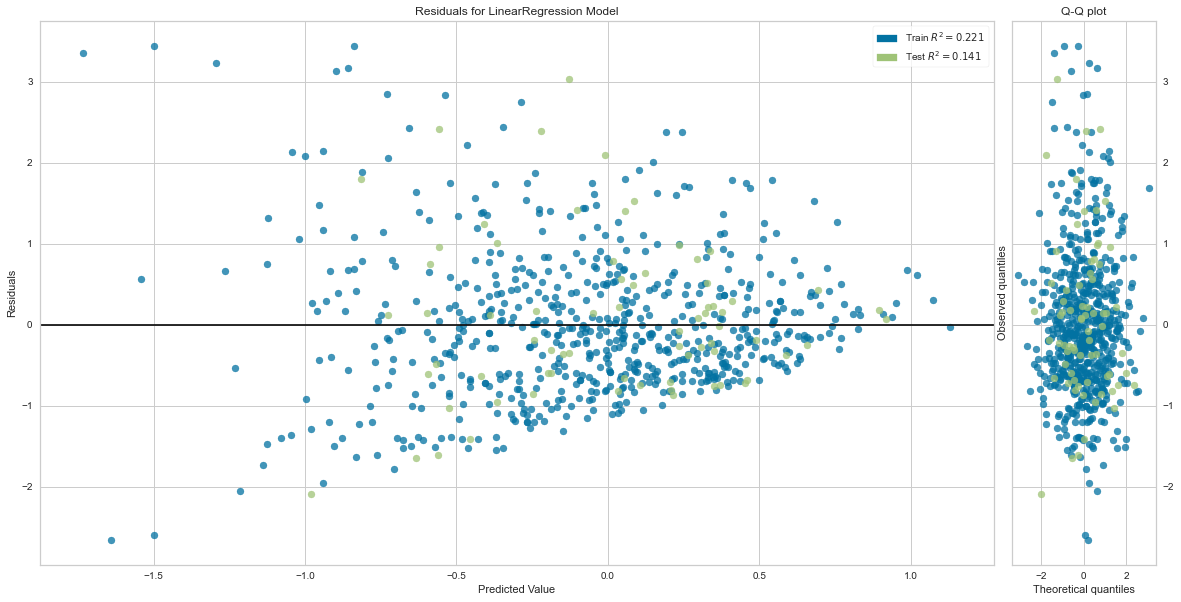

In [132]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_low = ResidualsPlot(linreg_low1, hist=False, qqplot=True)
visualizer_low.fit(X_train_low_train, y_train_low_train)
visualizer_low.score(X_train_low_test, y_train_low_test)
visualizer_low.show();
# plt.savefig('Linear Regression Model Lower plus QQ plot.png', dpi=300)

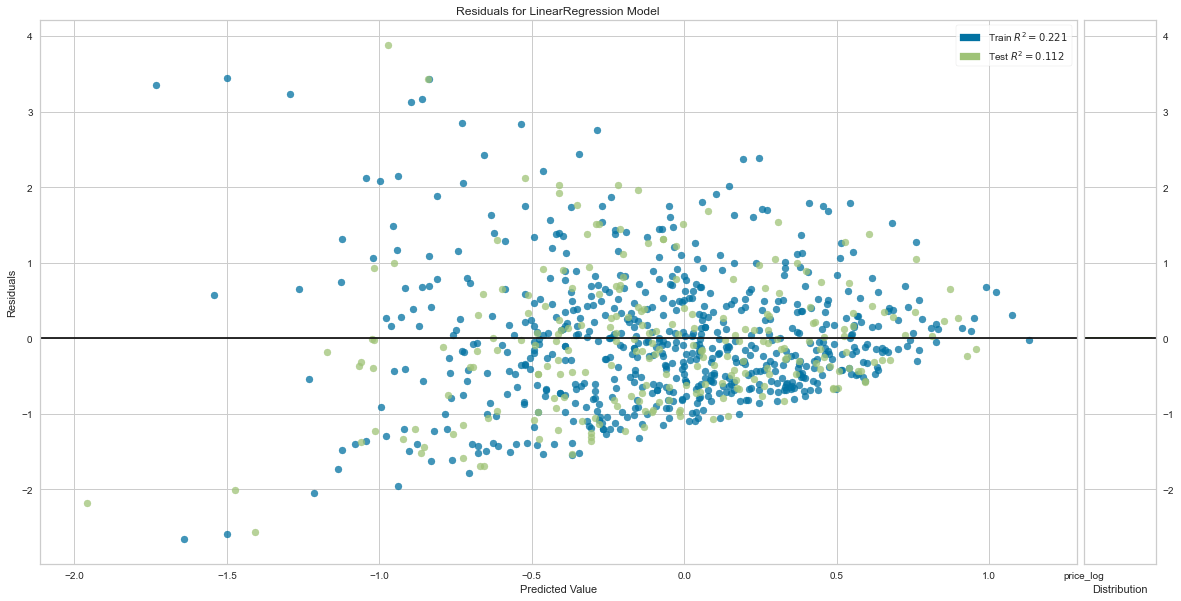

In [133]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_low = ResidualsPlot(linreg_low1)
visualizer_low.fit(X_train_low_train, y_train_low_train)
visualizer_low.score(X_test_low, y_test_low)
visualizer_low.show();
# plt.savefig('Linear Regression Model Lower Price.png', dpi=300)

## Middle Price Model

In [41]:
df_middle_price_pre = df.loc[(300000 <= df['price']) & (df['price'] < 650000)]
df_middle_price_pre.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
1,538000.0,small,minimal,2570,0.0,good,good,2170,400.0,47.7210,1690,11-50
3,604000.0,small,average,1960,0.0,very_good,good,1050,910.0,47.5208,1360,11-50
4,510000.0,small,minimal,1680,0.0,good,good,1680,0.1,47.6168,1800,Top_ten
9,323000.0,small,minimal,1890,0.0,good,good,1890,0.1,47.3684,2390,Top_ten
11,468000.0,small,minimal,1160,0.0,very_good,good,860,300.0,47.6900,1330,11-50


In [42]:
df_middle_price_pre.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15', 'state_rank'],
      dtype='object')

In [43]:
continuous = ["sqft_above", "price", "sqft_living15","sqft_living","lat"]

categorical = ['bathrooms',"grade","state_rank"]

df_log = np.log(df_middle_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df_middle_price_pre[continuous]]

    
df_norm = (np.log(df_middle_price_pre[continuous]) - np.mean(np.log(df_middle_price_pre[continuous])))/np.std(np.log(df_middle_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_middle_price_pre[continuous]]

oe=OrdinalEncoder(categories=[['small', 'moderate', 'excessive'],["bad","good",'very_good' ],['51-above','11-50','Top_ten' ]])
df_ohe=pd.DataFrame(oe.fit_transform(df_middle_price_pre[['bedrooms',"grade","state_rank"]]))
df_middle_price =df_norm.join(df_ohe, how="inner")

# df_ohe = pd.get_dummies(df_middle_price_pre[categorical], columns=categorical, drop_first = True)

# df_middle_price = pd.concat([df_norm, df_ohe], axis = 1)
#df_middle_price = pd.concat([df_final1,df_middle_price_pre.drop(columns=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront','condition', 'grade',
 #      'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'])], axis=1)

In [47]:
df_middle_price.head()

,sqft_above_log,price_log,sqft_living15_log,sqft_living_log,lat_log,0,1,2
1,0.942395,0.931581,-0.257614,1.018252,1.026767,0.0,1.0,1.0
3,-1.035681,1.468905,-1.070820,0.235002,-0.458946,0.0,1.0,2.0
4,0.245012,0.683397,-0.021569,-0.210591,0.254263,0.0,1.0,1.0
9,0.565955,-1.437556,1.039679,0.129876,-1.594130,0.0,1.0,1.0
11,-1.579599,0.284324,-1.154317,-1.281207,0.797120,0.0,1.0,1.0


In [45]:
X_middle = df_middle_price.drop(columns=['price_log'], axis=1) 
y_middle = df_middle_price[['price_log']]
X_train_middle, X_test_middle, y_train_middle, y_test_middle = train_test_split(X_middle, y_middle, random_state=50, test_size=.25)

In [46]:
f = y_train_middle, X_train_middle
model_mid = ols(formula=f, data=X_train_middle).fit()
model_mid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.248
Model:                            OLS   Adj. R-squared (uncentered):              0.247
Method:                 Least Squares   F-statistic:                              222.5
Date:                Fri, 02 Jul 2021   Prob (F-statistic):                   1.45e-286
Time:                        09:09:21   Log-Likelihood:                         -6003.4
No. Observations:                4722   AIC:                                  1.202e+04
Df Residuals:                    4715   BIC:                                  1.207e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
sqft_above_log       -0.0167      0.021     -0.790      0.429      -0.058       0.025
sqft_living15_log     0.1888      0.017     11.114      0.000       0.156       0.222
sqft_living_log       0.2984      0.021     13.966      0.000       0.256       0.340
lat_log               0.4255      0.013     31.951      0.000       0.399       0.452
0                    -0.0250      0.048     -0.518      0.605      -0.120       0.070
1                    -0.0113      0.022     -0.520      0.603      -0.054       0.031
2                    -0.0087      0.016     -0.563      0.573      -0.039       0.022
==============================================================================
Omnibus:                      283.535   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.641
Skew:                           0.059   Prob(JB):                     6.97e-24
Kurtosis:                       2.273   Cond. No.                         6.18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
df_middle_price.corr()['price_log'].map(abs).sort_values(ascending=False)

price_log            1.000000
lat_log              0.292501
sqft_living_log      0.268313
sqft_living15_log    0.247759
sqft_above_log       0.190731
1                    0.008346
0                    0.005438
2                    0.004484
Name: price_log, dtype: float64

In [49]:
linreg_mid = LinearRegression()
linreg_mid.fit(X_train_middle, y_train_middle)

predicted_y_middle = linreg_mid.predict(X_test_middle) 

linreg_mid.score(X_test_middle, y_test_middle)

0.2574411687948791

In [50]:
lr_middle = LinearRegression()

In [51]:
lr_middle.fit(X_train_middle, y_train_middle)

LinearRegression()

In [52]:
folds2 = KFold(10, shuffle = True)
train_train_scores_mid = []
train_test_scores_mid = []
train_train_rmse_mid = []
train_test_rmse_mid = []
for train_ind_mid, test_ind_mid in folds2.split(X_train_middle):
    X_train_mid_train = X_train_middle.iloc[train_ind_mid]
    X_train_mid_test = X_train_middle.iloc[test_ind_mid]
    y_train_mid_train = y_train_middle.iloc[train_ind_mid]
    y_train_mid_test = y_train_middle.iloc[test_ind_mid]
    linreg_mid = LinearRegression()
    linreg_mid.fit(X_train_mid_train, y_train_mid_train)
    train_train_scores_mid.append(linreg_mid.score(X_train_mid_train, y_train_mid_train))
    train_test_scores_mid.append(linreg_mid.score(X_train_mid_test, y_train_mid_test))
    train_train_rmse_mid.append(np.sqrt(mse(y_train_mid_train, linreg_mid.predict(X_train_mid_train))))
    train_test_rmse_mid.append(np.sqrt(mse(y_train_mid_test, linreg_mid.predict(X_train_mid_test))))

In [53]:
train_train_scores_mid

[0.25101333245770896,
 0.2478497548555082,
 0.2442756554269747,
 0.24612185503062922,
 0.250966984057737,
 0.2502469150145856,
 0.24900402663389487,
 0.24966803297612894,
 0.25223457620123935,
 0.24203385378089926]

In [54]:
train_test_scores_mid

[0.2204026600632515,
 0.2508303619458083,
 0.27846303859261845,
 0.26328082542031395,
 0.2200199640708984,
 0.2187731291669074,
 0.23986430839000372,
 0.2336334984464149,
 0.21233550440135185,
 0.29716035127579743]

In [55]:
train_train_rmse_mid

[0.8617170577398275,
 0.8646426742482334,
 0.8661133419120263,
 0.864529131915546,
 0.8597178508465269,
 0.8634073499526705,
 0.8621115826963471,
 0.862280847307095,
 0.8575404212364204,
 0.8650308525427828]

In [56]:
train_test_rmse_mid

[0.8730029631529538,
 0.8464209706227978,
 0.8342453304012898,
 0.8477094797419615,
 0.8914911763341503,
 0.8583130596864504,
 0.8693391447736178,
 0.8679311491809342,
 0.9094361009995163,
 0.8431192538097159]

In [112]:
display(linreg_mid.score(X_test_middle, y_test_middle),statistics.mean(train_train_scores_mid),statistics.mean(train_test_scores_mid))

0.25661890977828705

0.2483414986435306

0.2434763641773366

### Model visualizes

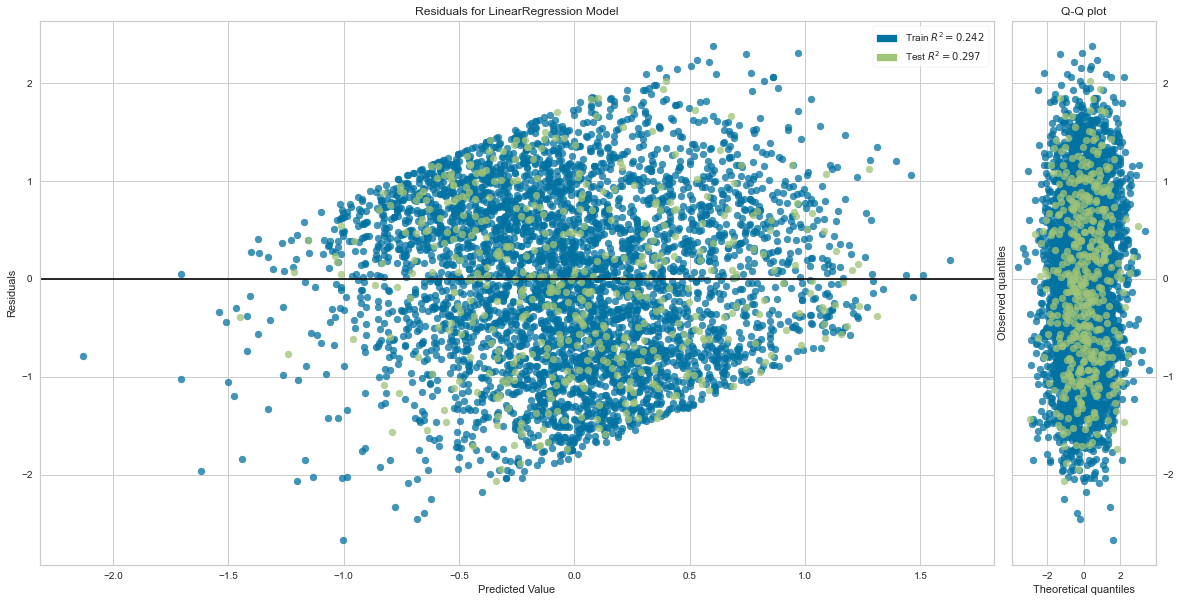

In [57]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_middle = ResidualsPlot(linreg_mid, hist=False, qqplot=True)
visualizer_middle.fit(X_train_mid_train, y_train_mid_train)
visualizer_middle.score(X_train_mid_test, y_train_mid_test)
visualizer_middle.show();
# plt.savefig('Linear Regression Model Middle Price plus QQ plot.png', dpi=300)

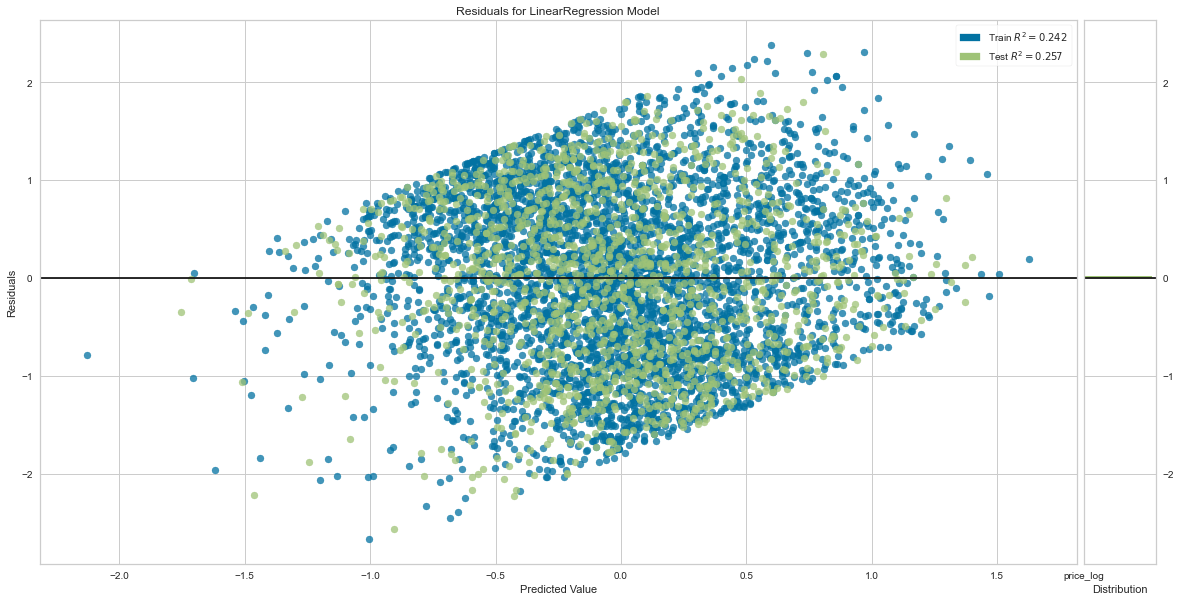

In [58]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_middle = ResidualsPlot(linreg_mid, hist=True)
visualizer_middle.fit(X_train_mid_train, y_train_mid_train)
visualizer_middle.score(X_test_middle, y_test_middle)
visualizer_middle.show();
# plt.savefig('Linear Regression Model Middle Price.png', dpi=300)

## Higher Price Model

In [61]:
df_higher_price_pre = df.loc[df['price']>= 650000]
df_higher_price_pre

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
5,1230000.0,small,average,5420,0.0,good,very_good,3890,1530.0,47.6561,4760,Top_ten
10,662500.0,small,minimal,3560,0.0,good,good,1860,1700.0,47.6007,2210,Top_ten
15,650000.0,small,average,2950,0.0,good,good,1980,970.0,47.5714,2140,11-50
21,2000000.0,small,minimal,3050,0.0,good,good,2330,720.0,47.5316,4110,Top_ten
26,937000.0,small,minimal,2450,0.0,good,good,1750,700.0,47.6386,1760,11-50
...,...,...,...,...,...,...,...,...,...,...,...,...
21221,869950.0,small,minimal,3140,0.0,good,good,3140,0.1,47.5923,3500,Top_ten
21226,750000.0,small,minimal,2810,0.0,good,good,2810,0.1,47.7081,2990,51-above
21227,729999.0,small,minimal,1630,0.0,good,very_good,1330,300.0,47.6113,1570,11-50
21232,890000.0,moderate,average,4100,0.0,good,very_good,4100,0.1,47.5955,3710,Top_ten


In [62]:
df_higher_price_pre.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15', 'state_rank'],
      dtype='object')

In [63]:
continuous = ["sqft_above", "price", "sqft_basement","sqft_living"]

categorical = ['bathrooms',"grade","state_rank", "waterfront"]

df_log = np.log(df_higher_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df_higher_price_pre[continuous]]

    
df_norm = (np.log(df_higher_price_pre[continuous]) - np.mean(np.log(df_higher_price_pre[continuous])))/np.std(np.log(df_higher_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_higher_price_pre[continuous]]

oe=OrdinalEncoder(categories=[['small', 'moderate', 'excessive'],["bad","good",'very_good' ],['51-above','11-50','Top_ten'],[0,1]])
df_ohe=pd.DataFrame(oe.fit_transform(df_higher_price_pre[['bedrooms',"grade","state_rank", "waterfront"]]))
df_higher_price =df_norm.join(df_ohe, how="inner")

# df_ohe = pd.get_dummies(df_middle_price_pre[categorical], columns=categorical, drop_first = True)
# df_higher_price = pd.concat([df_norm, df_ohe], axis = 1)

In [65]:
df_higher_price.head()

,sqft_above_log,price_log,sqft_basement_log,sqft_living_log,0,1,2,3
5,1.291443,0.850728,1.162223,1.939939,0.0,1.0,1.0,0.0
10,-0.604024,-0.978295,1.185531,0.677911,1.0,1.0,2.0,0.0
15,-0.443412,-1.034602,1.061404,0.113588,0.0,1.0,1.0,0.0
21,-0.025257,2.287738,0.995469,0.213679,0.0,2.0,2.0,0.0
26,-0.760630,0.046440,0.989237,-0.444015,0.0,1.0,1.0,0.0


In [97]:
while df_higher_price["sqft_basement_log"].loc[df_higher_price["sqft_basement_log"] == -0.78797255].count() > 0:
    for i in range(0, len(df_higher_price)):
        if df_higher_price["sqft_basement_log"].iloc[i] == -0.78797255:
            df_higher_price["sqft_basement_log"].iloc[i] = -2
# log base e of 0 on a graph could be read as -2. It technically goes to negative infinity but -2 will have to suffice for my estimations.

In [98]:
X_higher = df_higher_price.drop(columns=['price_log'], axis=1) 
y_higher = df_higher_price[['price_log']]
X_train_higher, X_test_higher, y_train_higher, y_test_higher = train_test_split(X_higher, y_higher, random_state=50, test_size=.25)

In [99]:
f = y_train_higher, X_train_higher
model_high = ols(formula=f, data=X_train_higher).fit()
model_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.353
Model:                            OLS   Adj. R-squared (uncentered):              0.348
Method:                 Least Squares   F-statistic:                              76.34
Date:                Fri, 02 Jul 2021   Prob (F-statistic):                    2.84e-88
Time:                        09:58:40   Log-Likelihood:                         -1227.3
No. Observations:                 988   AIC:                                      2469.
Df Residuals:                     981   BIC:                                      2503.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
sqft_above_log        0.4413      0.090      4.887      0.000       0.264       0.618
sqft_basement_log     0.3065      0.053      5.800      0.000       0.203       0.410
sqft_living_log       0.1813      0.083      2.193      0.029       0.019       0.343
0                     0.1166      0.067      1.744      0.081      -0.015       0.248
1                    -0.0086      0.033     -0.259      0.796      -0.073       0.056
2                     0.0039      0.032      0.122      0.903      -0.059       0.067
3                     0.2287      0.196      1.167      0.244      -0.156       0.613
==============================================================================
Omnibus:                      156.633   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.389
Skew:                           1.012   Prob(JB):                     1.74e-57
Kurtosis:                       4.500   Cond. No.                         13.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
df_higher_price.corr()['price_log'].map(abs).sort_values(ascending=False)

price_log            1.000000
sqft_living_log      0.551281
sqft_above_log       0.443930
sqft_basement_log    0.156226
0                    0.028993
2                    0.014078
1                    0.011560
3                    0.007328
Name: price_log, dtype: float64

In [101]:
linreg_high = LinearRegression()
linreg_high.fit(X_train_higher, y_train_higher)

predicted_y_higher = linreg_high.predict(X_test_higher) 

linreg_high.score(X_test_higher, y_test_higher)

0.1799423338158017

In [102]:
lr_higher = LinearRegression()

In [103]:
lr_higher.fit(X_train_higher, y_train_higher)

LinearRegression()

In [104]:
folds3 = KFold(10, shuffle = True)
train_train_scores_high = []
train_test_scores_high = []
train_train_rmse_high = []
train_test_rmse_high = []
for train_ind_high, test_ind_high in folds3.split(X_train_higher):
    X_train_high_train = X_train_higher.iloc[train_ind_high]
    X_train_high_test = X_train_higher.iloc[test_ind_high]
    y_train_high_train = y_train_higher.iloc[train_ind_high]
    y_train_high_test = y_train_higher.iloc[test_ind_high]
    linreg_high = LinearRegression()
    linreg_high.fit(X_train_high_train, y_train_high_train)
    train_train_scores_high.append(linreg_high.score(X_train_high_train, y_train_high_train))
    train_test_scores_high.append(linreg_high.score(X_train_high_test, y_train_high_test))
    train_train_rmse_high.append(np.sqrt(mse(y_train_high_train, linreg_high.predict(X_train_high_train))))
    train_test_rmse_high.append(np.sqrt(mse(y_train_high_test, linreg_high.predict(X_train_high_test))))

In [105]:
train_train_scores_high

[0.3567477077139881,
 0.3697511924677409,
 0.34402618928714157,
 0.3561351375782461,
 0.34015231365080756,
 0.352049829415894,
 0.3615940408447129,
 0.35994572219865895,
 0.3534413634102689,
 0.35274556128238665]

In [106]:
train_test_scores_high

[0.3209723871478153,
 0.11998180193923469,
 0.43640684986568923,
 0.33206704623828964,
 0.4106927885719983,
 0.3675212506819162,
 0.2763730946408619,
 0.2936208595484674,
 0.34919524061596907,
 0.362531886412632]

In [107]:
train_train_rmse_high

[0.8413956164114406,
 0.8414579378549405,
 0.8427236876124506,
 0.8427123000697748,
 0.8250153069319843,
 0.8367296045342014,
 0.8347959533693852,
 0.8302073109088444,
 0.8385391199765517,
 0.8320506923984805]

In [108]:
train_test_rmse_high

[0.7985581074381499,
 0.8036602910849054,
 0.7876662528028838,
 0.7843389808281724,
 0.9450207669096355,
 0.842482744185716,
 0.8606976234315075,
 0.9019979440030581,
 0.8264513599124205,
 0.8827737833752283]

### Model visualizes

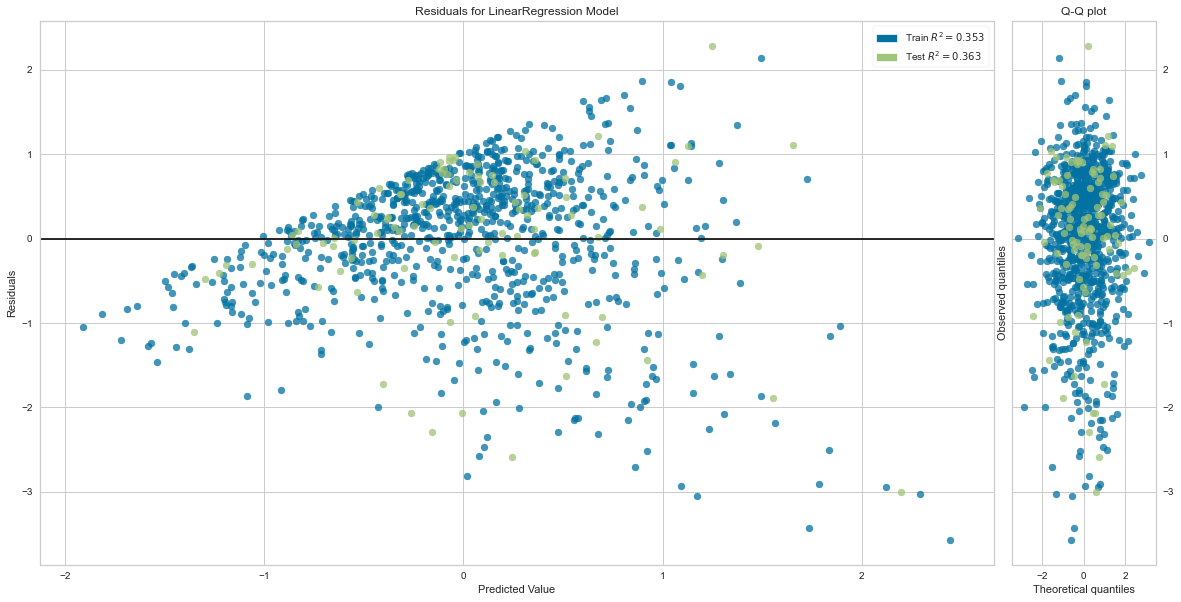

In [109]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_higher = ResidualsPlot(linreg_high, hist=False, qqplot=True)
visualizer_higher.fit(X_train_high_train, y_train_high_train)
visualizer_higher.score(X_train_high_test, y_train_high_test)
visualizer_higher.show();
# plt.savefig('Linear Regression Model Higher Price plus QQ plot.png',dpi=300);

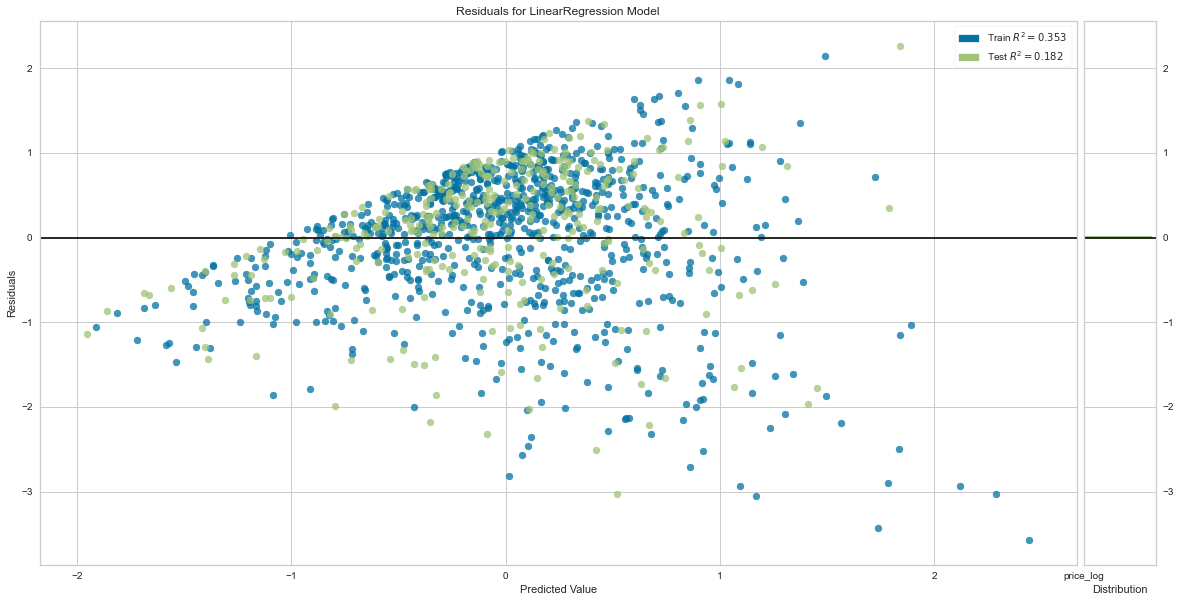

In [110]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_higher = ResidualsPlot(linreg_high)
visualizer_higher.fit(X_train_high_train, y_train_high_train)
visualizer_higher.score(X_test_higher, y_test_higher)
visualizer_higher.show();
# plt.savefig('Linear Regression Model High Price.png')